/Users/m.poinsinetdesivry-houle/Desktop/GitRepositories/FlowCyPy/FlowCyPy/acquisition.py:102: UserWarning: Multiple peaks detected in the following segments: [('forward', 0), ('forward', 1), ('forward', 2), ('forward', 3), ('forward', 4), ('forward', 5), ('forward', 6), ('forward', 7), ('forward', 8), ('forward', 9), ('forward', 10), ('forward', 11), ('forward', 12), ('forward', 13), ('forward', 14), ('forward', 15), ('forward', 16), ('forward', 17), ('forward', 18), ('forward', 19), ('forward', 20), ('forward', 21), ('forward', 22), ('forward', 23), ('forward', 24), ('forward', 25), ('forward', 26), ('forward', 27), ('forward', 28), ('forward', 29), ('forward', 30), ('forward', 31), ('forward', 32), ('forward', 33), ('side', 0), ('side', 1), ('side', 2), ('side', 3), ('side', 4), ('side', 5), ('side', 6), ('side', 7), ('side', 8), ('side', 9), ('side', 10), ('side', 11), ('side', 12), ('side', 13), ('side', 14), ('side', 15), ('side', 16), ('side', 17), ('side', 18), ('side', 19), ('s

True concentration: 	4.9e+07 particle / milliliter 
Measured concentration 	4.5e+07 particle / milliliter


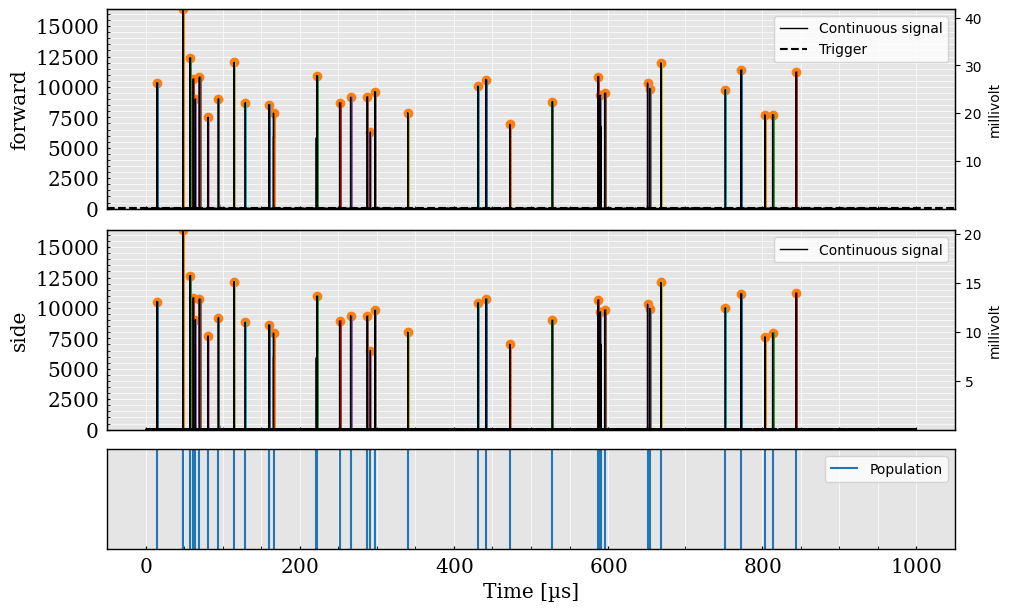

In [1]:
import numpy as np
from FlowCyPy import units
from FlowCyPy import NoiseSetting
from FlowCyPy import GaussianBeam
from FlowCyPy import FlowCell
from FlowCyPy import ScattererCollection
from FlowCyPy.population import Exosome, Population, distribution
from FlowCyPy.detector import Detector
from FlowCyPy.signal_digitizer import SignalDigitizer
from FlowCyPy import FlowCytometer
from FlowCyPy.classifier import KmeansClassifier

NoiseSetting.include_noises = True
NoiseSetting.include_shot_noise = True
NoiseSetting.include_thermal_noise = True
NoiseSetting.include_dark_current_noise = True

np.random.seed(1)  # Ensure reproducibility


RUN_TIME = 1.0 * units.millisecond
CONCENTRATION = 5e7 * units.particle / units.milliliter

source = GaussianBeam(
    numerical_aperture=0.3 * units.AU,           # Numerical aperture
    wavelength=200 * units.nanometer,           # Wavelength
    optical_power=20 * units.milliwatt          # Optical power
)

flow_cell = FlowCell(
    source=source,
    flow_speed=7.56 * units.meter / units.second,  # Flow speed
    flow_area=(10 * units.micrometer) ** 2,       # Cross-sectional area
)

signal_digitizer = SignalDigitizer(
    bit_depth='14bit',
    saturation_levels='auto',
    sampling_freq=60 * units.megahertz,
)

detector_0 = Detector(
    name='forward',
    phi_angle=0 * units.degree,                  # Forward scatter angle
    numerical_aperture=1.2 * units.AU,
    responsitivity=1 * units.ampere / units.watt,
    resistance=50 * units.ohm,
    temperature=300 * units.kelvin
)

detector_1 = Detector(
    name='side',
    phi_angle=90 * units.degree,                 # Side scatter angle
    numerical_aperture=1.2 * units.AU,
    responsitivity=1 * units.ampere / units.watt,
    resistance=50 * units.ohm,
    temperature=300 * units.kelvin,
)

scatterer_collection = ScattererCollection(medium_refractive_index=1.33 * units.RIU)

custom_population = Population(
    name='Population',
    particle_count=CONCENTRATION,
    size=distribution.RosinRammler(characteristic_size=150 * units.nanometer, spread=30),
    refractive_index=distribution.Normal(mean=1.44 * units.RIU, std_dev=0.002 * units.RIU)
)

scatterer_collection.add_population(custom_population)

scatterer_collection.dilute(factor=1)

cytometer = FlowCytometer(
    scatterer_collection=scatterer_collection,
    signal_digitizer=signal_digitizer,
    detectors=[detector_0, detector_1],
    flow_cell=flow_cell,
    background_power=0.001 * units.milliwatt
)

acquisition = cytometer.get_acquisition(run_time=RUN_TIME)

acquisition.run_triggering(
    threshold=0.1 * units.millivolt,
    trigger_detector_name='forward',
    max_triggers=35,
    pre_buffer=64,
    post_buffer=64
)

volume = cytometer.flow_cell.get_volume(run_time=RUN_TIME).to_compact()
n_particle = len(cytometer.scatterer_collection.dataframe) * units.particle
num_trigger = acquisition.data.triggered.index.get_level_values('SegmentID').nunique() * units.particle

true_concentration = (n_particle / volume).to('particle/milliliter')
measured_concentration = (num_trigger / volume).to('particle/milliliter')

print(f'True concentration: \t{true_concentration :.1e} \nMeasured concentration \t{measured_concentration :.1e}')

acquisition.plot.trigger()